### ⚠ IMPORTANT ⚠

You will need at least 15GB of VRAM (GPU RAM) to run this notebook.

If you're running this locally - please ensure you have the correct hardware to support the fine-tuning.

# Task Fine-tuning a GPT-style model using `peft`, `transformers` and `bitsandbytes`

In the following notebook, we'll task fine-tune a GPT-style model on the summarization task using:

- [QLoRA](https://arxiv.org/pdf/2305.14314.pdf)/[LoRA](https://arxiv.org/pdf/2106.09685.pdf)

The basic idea is that we will fine-tune an "adapter" which will represent a small subset of trainable weights on our task. This will allow us to instruct-tune a comparitively large model with consumer level resources.

The model we'll be instruct-tuning today is [`mistralai/Mistral-7B-Instruct-v0.2`](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2)!

#### ❓Question #1:

What makes Mistral-7B-Instruct-v0.2 a good model to use for a summarization task?

Answer: `Mistral-7B-instruct-v0.2 is finetuned version of Mistral-7b-instruct-v0.1 as has shown pretty good result in lot of benchmarks compared to other models like llama 2`

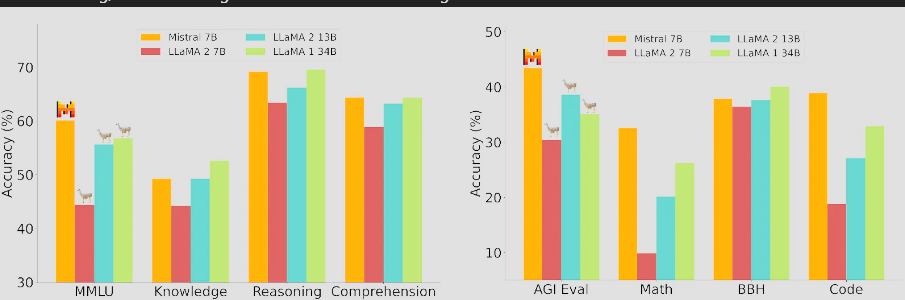

### Overview of PEFT and LoRA:

Based on some awesome research [here](https://github.com/huggingface/peft), we can leverage techniques like PEFT and LoRA to train/fine-tune large models a lot more efficiently.

It can't be explained much better than the overview given in the above link:

```
Parameter-Efficient Fine-Tuning (PEFT) methods enable efficient adaptation of
pre-trained language models (PLMs) to various downstream applications without
fine-tuning all the model's parameters. Fine-tuning large-scale PLMs is often
prohibitively costly. In this regard, PEFT methods only fine-tune a small
number of (extra) model parameters, thereby greatly decreasing the
computational and storage costs. Recent State-of-the-Art PEFT techniques
achieve performance comparable to that of full fine-tuning.
```

# 🤝 Breakout #1

### Setting Up Dependencies

We'll start by setting up the dependencies!

In [67]:
%pip install -qU bitsandbytes datasets accelerate loralib peft transformers trl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


We'll first verify we're in a GPU instance.

In [68]:
import torch
torch.cuda.is_available()

True

Time to import some dependencies!

In [69]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
import locale
locale.getpreferredencoding = lambda: "UTF-8"

## Task #1: Loading the Model

In the following task you will be expected to load the model from Hugging Face.

### Overview of Quantization:

Quantization is ultimately a simple concept with some very clever and tricky techniques that power it.

In today's notebook, we'll be exclusively focusing on the `bitsandbytes` quantization strategy which includes the idea of `k-bit` training.

Let's look at the QLoRA paper's definition of quantization:


```
Quantization is the process of discretizing an input from a representation that
holds more information to a representation with less information
```

Easy enough then!

Let's take a look at what that actually means.

### Block-wise k-bit Quantization

Ultimately, the QLoRA paper relies on a very specific form of quantization that relies on a few key ideas:

1. Model weights are mostly normally distributed
2. NF4 is a information-theoretically optimal data-type (this was later found to be [untrue](https://x.com/Tim_Dettmers/status/1668649436724199425?s=20), but NF4 is close to *empirically* optimal)


Let's think about quantization from a very high level - and use some oversimplifications to understand what's really happening under the hood.

In essence, we can think of quantization as placing a pin on the number line (our quantization constant) and then expressing a low-precision zero-centered size-64 block range around that pinned number. Exploiting the fact that our weights are normally distributed and that we scale them to be in the range [-1, 1], this lets use use our NF4 datatype to roughly optimally express our high precision weights in a low precision format. While we still do need *some* higher precision numbers - this process lets use represent many numbers in low precision for the cost of 1 number in high precision.

However, we can take it one step further - and we can actually quantize the range of quantization constants we wind up with as well! This winds up saving us ~0.373 bits per parameter.

Leveraging the work done in [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) means we need to set some specific hyper-parameters for our [`quantization_config`](https://github.com/huggingface/transformers/blob/2fc33ebead50383f7707b17f0e2a178d86347d10/src/transformers/utils/quantization_config.py#L151).

- `load_in_4bit` - we'll want to set this to true so we can load and train our model on a single 40GB GPU.
- `bnb_4bit_quant_type` - setting this to the desired format of `nf4` will ensure we're using the most memory efficient datatype for 4bit storage.
- `bnb_double_quant` - setting this to true will save us memory by quantizing the quantization config
- `bnb_4bit_compute_dtype` - since we will not use a 4-bit representation to compute, we need to provide a desired format for our compute type so our weights can be upcast to something while we flow information through our network.



In [70]:
bnb_config = BitsAndBytesConfig(
    # load_in_8bit=True,
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

Now we can load the model.

In [71]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [72]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [222]:
tokenizer.pad_token = tokenizer.unk_token
tokenizer.padding_side = "right"
# tokenizer.padding_side = "left"

#if tokenizer.pad_token_id is None:
  #tokenizer.pad_token_id = tokenizer.eos_token_id

### Model Architecture

It's important to observe the model's construction!

This one should look familiar!

In [223]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): MistralForCausalLM(
          (model): MistralModel(
            (embed_tokens): Embedding(32000, 4096)
            (layers): ModuleList(
              (0-31): 32 x MistralDecoderLayer(
                (self_attn): MistralSdpaAttention(
                  (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
                  (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
                  (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
                  (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
                  (rotary_emb): MistralRotaryEmbedding()
                )
                (mlp): MistralMLP(
                  (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
                  (up_proj): Linear4bit(in_features=4096, out_features=14336,

In [275]:
model.config

MistralConfig {
  "_name_or_path": "mistralai/Mistral-7B-Instruct-v0.2",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_theta": 1000000.0,
  "sliding_window": null,
  "tie_word_embeddings": false,
 

#### ❓Question #2:

![image](https://i.imgur.com/N8y2crZ.png)

Label the image with the appropriate layer from `mistralai/Mistral-7B-Instruct-v0.2`'s architecture.

- EXAMPLE - Layer Norm: `post_attention_layernorm`/`input_layernorm`
- Feed Forward: `MistralMLP`/ 


          `(gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()`
      
- Masked Multi Self-Attention: ` MistralSdpaAttention/`/`(self_attn): MistralSdpaAttention`
  
  `(self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding())`

- Decoder layer: `MistralDecoderLayer`  (contains 32 layers)

- Text & Position Embed: `(embed_tokens): Embedding(32000, 4096)`

- Text Prediction: `(lm_head): Linear(in_features=4096, out_features=32000, bias=False)`

# 🤝 Breakout #2:

## Task #2: Data and Data Preparation

Since we'll be focusing on summarization fine-tuning - we'll need to find a summarization dataset!

There are a few good examples available to use on the Hugging Face [dataset](https://huggingface.co/datasets?task_categories=task_categories:summarization&sort=trending) hub - let's check a few of them out!

> NOTE: The link above is pre-filtered to include datasets with the summarization tag

### Summarization Datasets

Let's see what is available for us:

- [`databricks/databricks-dolly-15k`](https://huggingface.co/datasets/databricks/databricks-dolly-15k)
  - this dataset is comprised of ~15K rows of various tasks of which ~7% is summarization data
- [`samsum`](https://huggingface.co/datasets/samsum)
  - this dataset contains ~16K conversations in messenger format as well as their summaries
- [`CohereForAI/aya_collection`](https://huggingface.co/datasets/CohereForAI/aya_collection)
  - similar to Dolly-15K, this dataset contains a wide range of *multilingual* tasks - a subset of which is summarization

For simplicities sake - we'll stick with the `samsum` (here's the [paper](https://arxiv.org/abs/1911.12237v2)) dataset as it's a focused summarization dataset.

The first step will be to load the dataset!

> NOTE: While we're going to use a subset of the data for illustrative reasons  - you could use the full dataset and train the model on the task to completion

In [294]:
from datasets import load_dataset

dataset_name = "samsum"
#dataset_name = "databricks/databricks-dolly-15K"
#dataset_name = "CohereForAI/aya_collection"
dataset = load_dataset(dataset_name)
#dataset = load_dataset("CohereForAI/aya_collection", "templated_mintaka")

Let's check how many items we have in each of our training, validation, and test subsets.

In [295]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

We'll select only a small portion of each in order to keep our example reasonable.

In [296]:
dataset["test"].select(range(819)) #= dataset["test"].select(range(50))
#dataset["test"]

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 819
})

In [297]:
dataset["train"] = dataset["train"].select(range(4000))

In [298]:
dataset["validation"] = dataset["validation"].select(range(818))


In [299]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

Let's look at a single example to see the format we're working with!

We want to put our data in the format:

```
<s>[INST]Provide a summary of the following text:

[INPUT_TEXT_START]
TEXT_TO_SUMMARIZE
[INPUT_TEXT_END]

[/INST]

SUMMARY</s>
```

The more general idea here is that we want to show our model examples of a prompt, and its completion.

Here's a specific example!

```
<s>[INST]Provide a summary of the following text:

[INPUT_TEXT_START]
Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)
[INPUT_TEXT_END]

[/INST]

Amanda baked cookies and will bring Jerry some tomorrow.</s>
```

#### 🏗️ Activity #1: Creating the `create_prompt` function

We'll create a function that will take a row of our dataset, along with a default False flag that creates the prompt in the format expressed above.

In [282]:
def create_prompt(sample, include_response = True):
  """
  Parameters:
    - sample: dict representing row of dataset
    - include_response: bool

  Functionality:
    This function should build the Python str `full_prompt`.

    If `include_response` is true, it should include the summary -
    else it should not contain the summary (useful for prompting) and testing

  Returns:
    - full_prompt: str
  """

  ### YOUR CODE HERE

  return f"""<s>[INST]Provide a summary of the following text:
             \n[INPUT_TEXT_START]\n{sample["dialogue"]}\n[INPUT_TEXT_END]
             \n[/INST]
             \n{sample["summary"] if include_response else ""}</s>"""



 # return full_prompt

In [283]:
print(create_prompt(dataset["test"][1]))

<s>[INST]Provide a summary of the following text:
             
[INPUT_TEXT_START]
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)
[INPUT_TEXT_END]
             
[/INST]
             
Eric and Rob are going to watch a stand-up on youtube.</s>


In [300]:
def generate_response(prompt, model, tokenizer):
  """
  Parameters:
    - prompt: str representing formatted prompt
    - model: model object
    - tokenizer: tokenizer object

  Functionality:
    This will allow our model to generate a response to a prompt!

  Returns:
    - str response of the model
  """

  # convert str input into tokenized input
  encoded_input = tokenizer(prompt,  return_tensors="pt",padding='max_length')

  print("encoded_input")
  print( encoded_input)


  # send the tokenized inputs to our GPU
  model_inputs = encoded_input.to('cuda')

  # generate response and set desired generation parameters
  generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=256,
      do_sample=True,
      pad_token_id=tokenizer.eos_token_id
  )

  # decode output from tokenized output to str output
  decoded_output = tokenizer.batch_decode(generated_ids)

  print("decoded output")
  print(decoded_output)
  print(decoded_output[0].split("[/INST]")[-2])

  # return only the generated response (not the prompt) as output
  # return decoded_output[0].split("[/INST]")[-1]
  return decoded_output[0].split("[/INST]")[-1]
  # return decoded_output[0]

In [301]:
generate_response(create_prompt(dataset["test"][1], include_response=False),
                  model,
                  tokenizer)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


encoded_input
{'input_ids': tensor([[    1,     1,   733, 16289, 28793, 18325,   547,   264, 14060,   302,
           272,  2296,  2245, 28747,    13,   569,    13, 28792, 20309, 28730,
          9219, 28730, 12241, 28793,    13, 28749,  1491, 28747,   351, 16522,
          5472, 28808, 28801,    13, 22268, 28747,  1725, 28742, 28713,   579,
           847, 28783, 28808, 28801,    13, 28749,  1491, 28747,   315,   873,
         28808,  1015,  4370,   910,  8165,  1032,  8098,  2753,  3174,    13,
         22268, 28747,  1015,   378, 28742, 28713,  1528, 10032, 28808, 28801,
            13, 28749,  1491, 28747,   315,   873, 28808,   315,  4012,   737,
           272,  5835,   744, 28808, 28801,    13, 22268, 28747,   382,   912,
         12980, 28808,  1770,   624, 15066,   298,   272,  5599,   737,   369,
         28808, 28801,    13, 28749,  1491, 28747,  1691,   456,   516,   865,
          1876, 28733,   715, 28804, 28801,    13, 22268, 28747,  6318, 28729,
         28723,   315, 2

'<s><s> [INST]Provide a summary of the following text:\n             \n[INPUT_TEXT_START]\nEric: MACHINE!\r\nRob: That\'s so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it\'s really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I\'ll check.\r\nEric: Sure.\r\nRob: Turns out no! There are some of his stand-ups on youtube.\r\nEric: Gr8! I\'ll watch them now!\r\nRob: Me too!\r\nEric: MACHINE!\r\nRob: MACHINE!\r\nEric: TTYL?\r\nRob: Sure :)\n[INPUT_TEXT_END]\n             \n[/INST]\n             \n</s>Two friends, Eric and Rob, have a conversation about a stand-up comedian named MACHINE. They find his performance amusing, particularly the train part, and express their enthusiasm towards it. They wonder if it\'s his only stand-up comedy show and decide to check if there are more performances available on YouTube. After discovering that there are oth

In [271]:
# Ground Truth Summary
dataset["test"][1]["summary"]

'Eric and Rob are going to watch a stand-up on youtube.'

Let's try another just to see how the model responds to a different prompt.

In [274]:
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

generate_response(create_prompt(dataset["test"][3], include_response=False),
                  model,
                  tokenizer)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


"\n             \n</s>[Summarization]\nWill asks Emma what she wants for dinner but she tells him not to worry about it as she's not feeling well. She intends to come home soon but asks Will not to pick her up. She also mentions that she's not hungry. Will expresses his love for her, and she returns the sentiment. Emma does not mention the reason for her feeling unwell.</s>"

In [273]:
# Ground Truth Summary
dataset["test"][3]["summary"]

'Emma will be home soon and she will let Will know.'

The response, while an accurate *recounting* of the conversation is certainly not what would be consider to be a summary.

Let's see how fine-tuning can improve these responses.

### Required Post Processing

Finally, we need to apply some post-processing on the 4-bit model to enable training, let's freeze all our layers, and cast the layer-norm in `float32` for stability. We also cast the output of the last layer in `float32` for the same reasons.

Instead of doing this manually, of course, we can use the helper function `prepare_model_for_kbit_training`! You can look at the source code [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/utils/other.py#L67)

In [184]:
from peft import prepare_model_for_kbit_training
model.config.use_cache = False
model = prepare_model_for_kbit_training(model)

## Task #3: Setting up PEFT LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

#### Helper Function to Print Parameter %age

This is just a helper function to print out just how much LoRA reduces the number of trainable parameters.

In [185]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

#### Initializing LoRA Config

There's a lot to unpack here - so let's talk about the main parameters:

- `r`: is the "rank" of the two decomposed matrices we'll be using to represent our weight matrix. In reality, this is the dimension of the decomposed matrices.

Here is an exerpt from the paper to help provide context for the selected `r`

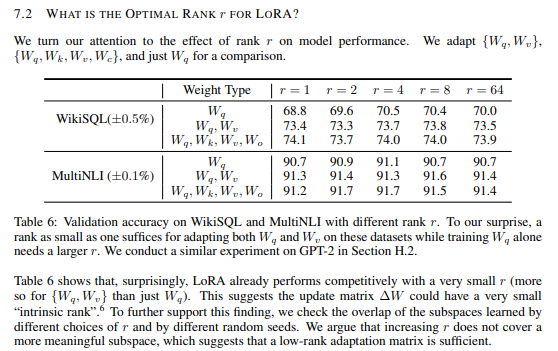


- `target_modules`: As LoRA can be applied to *any* weight matrix - we need to configure *which* module (weight matrix) it's being applied to. The LoRA paper suggests applying it to the Attention weights, but the QLoRA paper suggests we apply it to all Linear layers. Thus, we'll omit `target_module` from our hyper-parameters.


- `task_type`: This is a derived property. If you're using a causal model, this should be set to `CAUSAL_LM`. Please ensure this property is set based on your selected model.

Again, while this is the way we're leveraging LoRA in this notebook - it can be used in conjunction with many different models - and many different tasks. You can even use it for tasks like [token classification!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)

In [186]:
from peft import LoraConfig, get_peft_model

# # set our rank (higher value is more memory/better performance)
# lora_r = 16

# # set our dropout (default value)
# lora_dropout = 0.1

# # rule of thumb: alpha should be (lora_r * 2)
# lora_alpha = 32

# # construct our LoraConfig with the above hyperparameters
# peft_config = LoraConfig(
#     lora_alpha=lora_alpha,
#     lora_dropout=lora_dropout,
#     r=lora_r,
#     bias="none",
#     task_type="CAUSAL_LM"
# )
     

# set our rank (higher value is more memory/better performance)
lora_r = 32

# set our dropout (default value)
lora_dropout = 0.1

# rule of thumb: alpha should be (lora_r * 2)
lora_alpha = 64

# construct our LoraConfig with the above hyperparameters
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

Now that we have our PEFT config - we need to convert our model into a PEFT model!

We can use the convenient helper function `get_peft_model` to do so.

Documentation found [here](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/mapping.py#L98)!

In [187]:
model = get_peft_model(
    model,
    peft_config
)

print_trainable_parameters(model)

trainable params: 13631488 || all params: 3765702656 || trainable%: 0.36199055648434075


In [188]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): MistralForCausalLM(
          (model): MistralModel(
            (embed_tokens): Embedding(32000, 4096)
            (layers): ModuleList(
              (0-31): 32 x MistralDecoderLayer(
                (self_attn): MistralSdpaAttention(
                  (q_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=4096, out_features=32, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=32, out_features=4096, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
 

#### ❓Question #3:

What modules (or groupings of layers) did we apply LoRA too - and how can we tell from the model summary?

we applyed LoRa to the attention layers and is reprented in the attention part as follows: `lora.Linear4bit`/` (lora_dropout): ModuleDict`/`lora_A): ModuleDict`/ `(lora_B): ModuleDict`/`(lora_embedding_A): ParameterDict()`/`(lora_embedding_B): ParameterDict()))`

Here you see the whole attentionlayer:
    
    
                    `(self_attn): MistralSdpaAttention(
                      (q_proj): lora.Linear4bit(
                        (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                        (lora_dropout): ModuleDict(
                          (default): Dropout(p=0.1, inplace=False)
                        )
                        (lora_A): ModuleDict(
                          (default): Linear(in_features=4096, out_features=16, bias=False)
                        )
                        (lora_B): ModuleDict(
                          (default): Linear(in_features=16, out_features=4096, bias=False)
                        )
                        (lora_embedding_A): ParameterDict()
                        (lora_embedding_B): ParameterDict()))`


## Task #4: Training the Model

Now we'll be training our model with the created dataset!



### Setting up Training

The `Trainer` class contains all the usual suspects - these are the same hyper-parameters you know and love from from previous notebooks!

If you're running into CUDA memory issues - please modify both the `per_device_train_batch_size` to be lower, and also reduce `r` in your LoRAConfig. You'll need to restart and re-run your notebook after doing so.

In [189]:
from transformers import TrainingArguments

# args = TrainingArguments(
#   output_dir = "mistral7binstruct_summarize",
#   #num_train_epochs=5,
#   max_steps = 50, # comment out this line if you want to train in epochs
#   per_device_train_batch_size = 1,
#   warmup_steps = 0.03,
#   logging_steps=10,
#   #evaluation_strategy="epoch",
#   evaluation_strategy="steps",
#   eval_steps=25, # comment out this line if you want to evaluate at the end of each epoch
#   learning_rate=2e-4,
#   lr_scheduler_type='constant',
# )

# args = TrainingArguments(
#   output_dir = "mistral7binstruct_summarize",
#   #num_train_epochs=5,
#   max_steps = 150, # comment out this line if you want to train in epochs
#   per_device_train_batch_size = 1,
#   warmup_steps = 0.03,
#   logging_steps=10,
#   #evaluation_strategy="epoch",
#   evaluation_strategy="steps",
#   eval_steps=25, # comment out this line if you want to evaluate at the end of each epoch
#   learning_rate=2e-4,
#   lr_scheduler_type='constant',
# )
     
     

args = TrainingArguments(
  output_dir = "mistral7binstruct_summarize",
  #num_train_epochs=5,
  max_steps = 150, # comment out this line if you want to train in epochs
  per_device_train_batch_size = 1,
  warmup_steps = 0.03,
  logging_steps=2,
  #evaluation_strategy="epoch",
  evaluation_strategy="steps",
  eval_steps=5, # comment out this line if you want to evaluate at the end of each epoch
  learning_rate=2.0e-05,
  gradient_accumulation_steps=2,
  lr_scheduler_type='cosine',
  seed=42,

)

#### ❓Question #4:

Describe what the following parameters are doing:

- `warmup_steps`  - is the amount of steps you will do for the linear warmup
- `learning_rate`  - it's the initial learning rate
- `lr_scheduler_type` - is what sceduler type to use - typical scheduler contains what optimizer it should use
during training, the number of warmups steps to do, number of training steps to do

> NOTE: Feel free to consult the [documentation](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) or other resources!

In [190]:
dataset["train"]
dataset["train"][1]

{'id': '13728867',
 'dialogue': 'Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great',
 'summary': 'Olivia and Olivier are voting for liberals in this election. '}

In [191]:
dataset["validation"][1]

{'id': '13716628',
 'dialogue': 'Emma: I’ve just fallen in love with this advent calendar! Awesome! I wanna one for my kids!\r\nRob: I used to get one every year as a child! Loved them! \r\nEmma: Yeah, i remember! they were filled with chocolates!\r\nLauren: they are different these days! much more sophisticated! Haha!\r\nRob: yeah, they can be fabric/ wooden, shop bought/ homemade, filled with various stuff\r\nEmma: what do you fit inside?\r\nLauren: small toys, Christmas decorations, creative stuff, hair bands & clips, stickers, pencils & rubbers, small puzzles, sweets\r\nEmma: WOW! That’s brill! X\r\nLauren: i add one more very special thing as well- little notes asking my children to do something nice for someone else\r\nRob: i like that! My sister adds notes asking her kids questions about christmas such as What did the 3 wise men bring? etc\r\nLauren: i reckon it prepares them for Christmas \r\nEmma: and makes it more about traditions and being kind to other people\r\nLauren: my 

In [192]:
from trl import SFTTrainer

max_seq_length = 2048

trainer = SFTTrainer(
  model=model,
  peft_config=peft_config,
  max_seq_length=max_seq_length,
  tokenizer=tokenizer,
  packing=True,
  formatting_func=create_prompt,
  args=args,
  train_dataset=dataset["train"],
  eval_dataset=dataset["validation"]
)


# max_seq_length = 2048

# trainer = SFTTrainer(
#   model=model,
#   peft_config=peft_config,
#   max_seq_length=max_seq_length,
#   tokenizer=tokenizer,
#   packing=True,
#   formatting_func=create_prompt,
#   args=args,
#   train_dataset=dataset["train"],
#   eval_dataset=dataset["validation"]
# )

/home/markt/anaconda3/envs/llmops-course/lib/python3.11/site-packages/trl/trainer/utils.py:434: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/markt/anaconda3/envs/llmops-course/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/home/markt/anaconda3/envs/llmops-course/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [194]:
import wandb

os.environ["WANDB_NOTEBOOK_NAME"] = "Fine_tuning_Mistral_7B_Instruct_for_Summarization_Assignment_Version.ipynb"

settings=wandb.Settings(disable_job_creation=True)


wandb.init(project="FineTuning", settings=settings)


> NOTE: The following cell should take ~45min. or so to complete on a T4 GPU with the pre-set hyper-parameters.

In [195]:
trainer.train()

/home/markt/anaconda3/envs/llmops-course/lib/python3.11/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
5,2.517200,2.392617
10,2.282200,2.153704
15,2.110900,2.008740
20,1.857100,1.902017
25,1.896400,1.831020
30,1.733500,1.790133
35,1.774400,1.760695
40,1.865400,1.739588
45,1.737900,1.723454
50,1.744200,1.711254


TrainOutput(global_step=150, training_loss=1.7523713604609172, metrics={'train_runtime': 1792.1544, 'train_samples_per_second': 0.167, 'train_steps_per_second': 0.084, 'total_flos': 2.62629884952576e+16, 'train_loss': 1.7523713604609172, 'epoch': 0.64})

## Task #5: Share Your Model!

Normally, we would only seek to push the LoRA adapters to the hub. This is a lightweight and memory efficient way to push this model - as you can pull the base model down as part of the inference pipeline.

However, if you want to leverage the one-click-deploy features of Hugging Face, you'll need to first `merge_and_unload()` the model and push the resulting model to the hub. This process will merge the LoRA weights back into the base model.

If you run into issues during upload - please ensure you're using a HF Token with `WRITE` access!

In [196]:
from huggingface_hub import notebook_login

notebook_login()

In [200]:
# trainer.push_to_hub("ai-maker-space/mistral-7binstruct-summary-100s")
trainer.push_to_hub("markat1/mistral-7binstruct-summary-100s")

adapter_model.safetensors:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/HeRksTAn/mistral7binstruct_summarize/commit/96f6c1bdf3ee007768d04944be6b9571f280a2db', commit_message='markat1/mistral-7binstruct-summary-100s', commit_description='', oid='96f6c1bdf3ee007768d04944be6b9571f280a2db', pr_url=None, pr_revision=None, pr_num=None)

### Compare Outputs

Let's see how our model fairs at this task, now!

In [286]:
merged_model = model.merge_and_unload()

#### ❓Question #5:

What does the `merge_and_unload()` method do?

merge_and_load() method merges the LoRa layer into a base model - reason we do this is to turn the model into a standalone model

> NOTE: Check out the [documentation](https://huggingface.co/docs/trl/v0.7.11/use_model) or the [source code](https://github.com/huggingface/peft/blob/096fe537370cf8a2cb55cc9bd05c7812ca919405/src/peft/tuners/lora/model.py#L685) to find out!

In [288]:
generate_response(create_prompt(dataset["test"][1], include_response=False),
                  merged_model,
                  tokenizer)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


'\n             \n</s>two friends, Eric and Rob, are discussing a stand-up comedy clip of a Russian comedian named MACHINE. They find the performance amusing and appreciate the unique way the comedian interacts with the machine during the performance. They are unsure if this is MACHINE\'s only stand-up, so they agree to check if there are more on YouTube. Eventually, they discover that there are more videos and decide to watch them together over the phone, saying "TYTL" (talk to you later) before ending the call.</s>'

Let's look at the base model response:

> *Eric and Rob are having a conversation about a stand-up comedy performance by an unnamed comedian named "Machine." They find the performance hilarious, particularly a part involving a train. They discuss how Americans perceive Russians based on the comedy routine. Eric wonders if this is Machine\'s only stand-up performance, and Rob agrees to help him find more of Machine\'s comedy content on YouTube. They both express excitement and plan to watch the other performances together. They sign off with the phrase "talk to you later" (TTYL) before ending the conversation.</s>*

Now the fine-tuned response:

> *Eric and Rob watched a MACHINE comedy stand-up video and found it funny. Eric is especially impressed by the Russian accent in the video. He asks Rob if that was MACHINE'S only stand-up and if there are any others. Rob confirms that there are several MACHINE'S stand-up videos on Youtube. Eric and Rob agree to watch them together.</s>*



We can see that, directionally, our model is getting much closer to our desired results with only *100* steps of training.

Let's try another example to make sure it wasn't a fluke!

In [289]:
print(dataset["test"][3]["dialogue"])

Will: hey babe, what do you want for dinner tonight?
Emma:  gah, don't even worry about it tonight
Will: what do you mean? everything ok?
Emma: not really, but it's ok, don't worry about cooking though, I'm not hungry
Will: Well what time will you be home?
Emma: soon, hopefully
Will: you sure? Maybe you want me to pick you up?
Emma: no no it's alright. I'll be home soon, i'll tell you when I get home. 
Will: Alright, love you. 
Emma: love you too. 


In [290]:
generate_response(create_prompt(dataset["test"][3], include_response=False),
                  merged_model,
                  tokenizer)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


"\n             \n</s> Both Will and Emma are having a text conversation. Will asks Emma what she wants for dinner, to which she responds that she's not hungry and it's not necessary for him to worry about cooking. Emma explains that she's not feeling well but is going to be home soon. Will offers to pick her up, but she declines and assures him that she will let him know when she gets home. They both express their love for each other before the conversation ends.</s>"

In [291]:
# Ground Truth Summary
dataset["test"][3]["summary"]

'Emma will be home soon and she will let Will know.'

Lets look at the base model response:

>  *Emma won't be home for dinner tonight, she has a problem, but she doesn't want Will to worry. She'll let him know when she's home. She'll be coming soon.</s>*

And the fine-tuned model:

> *Emma is not feeling well. She will be home soon. She doesn't want Will to cook anything for dinner.</s>*

And again, we can see that the model performs the task *better* than the original un-fine-tuned model - though there is still work to do.